In [1]:
import argparse
import logging
import os
import torch
from torch.utils.data import DataLoader, random_split
import json
import rdkit.Chem as Chem
#from rxntorch.models.reactivity_network import ReactivityNet as RxnNet, ReactivityTrainer as RxnTrainer
#from rxntorch.utils import collate_fn
import rdkit
from rxntorch.containers.reaction import Rxn
from rxntorch.containers.molecule import Mol
from rxntorch.containers.dataset import RxnGraphDataset as RxnGD
from rxntorch.utils import collate_fn
from rxntorch.models.yield_network import YieldNet as RxnNet, YieldTrainer as RxnTrainer


from rdkit.Chem import Draw
from collections import defaultdict

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("-p", "--dataset_path", type=str, default='./data/', help="train dataset")
parser.add_argument("-c", "--train_dataset", required=True, type=str, help="train dataset")
parser.add_argument("-t", "--test_dataset", type=str, default=None, help="test set")
parser.add_argument("-op", "--output_path", type=str, default='./saved_models/', help="saved model path")
parser.add_argument("-o", "--output_name", required=True, type=str, help="e.g. rxntorch.model")
parser.add_argument("-ds", "--test_split", type=float, default=0.2, help="Ratio of samples to reserve for test data")

parser.add_argument("-b", "--batch_size", type=int, default=20, help="number of batch_size")
parser.add_argument("-tb", "--test_batch_size", type=int, default=None, help="batch size for evaluation")
parser.add_argument("-e", "--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("-hs", "--hidden", type=int, default=300, help="hidden size of model layers")
parser.add_argument("-l", "--layers", type=int, default=3, help="number of layers")

parser.add_argument("--lr", type=float, default=1e-3, help="learning rate of the optimizer")
parser.add_argument("-lrd", "--lr_decay", type=float, default=0.9,
                    help="Decay factor for reducing the learning rate")
parser.add_argument("-lrs", "--lr_steps", type=int, default=10000,
                    help="Number of steps between learning rate decay")
parser.add_argument("--adam_weight_decay", type=float, default=0.0, help="weight_decay of adam")
parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam second beta value")
parser.add_argument("-gc", "--grad_clip", type=float, default=None, help="value for gradient clipping")
parser.add_argument("-pw", "--pos_weight", type=float, default=None, help="Weights positive samples for imbalance")

parser.add_argument("-w", "--num_workers", type=int, default=4, help="dataloader worker size")
parser.add_argument("--with_cuda", type=bool, default=True, help="training with CUDA: true, or false")
parser.add_argument("--cuda_devices", type=int, nargs='*', default=None, help="CUDA device ids")

parser.add_argument("--log_freq", type=int, default=50, help="printing loss every n iter: setting n")



_StoreAction(option_strings=['--log_freq'], dest='log_freq', nargs=None, const=None, default=50, type=<class 'int'>, choices=None, help='printing loss every n iter: setting n', metavar=None)

In [3]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')


In [4]:
m.GetNumAtoms()
Chem.MolToSmiles(m)
from rdkit.Chem import AllChem
#AllChem.Compute2DCoords(m2)
#for atom in m.GetAtoms():
    #print(atom.GetSymbol(),atom.GetIdx())
#print(Chem.MolToMolBlock(m))

In [5]:
#args = parser.parse_args()
args = parser.parse_args(args=['-p','data/','-c', 'doyle_reactions_data.json', '-o', 'model.01'])

#args.dataset_path="/afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/data/"
#args.train_dataset="doyle_reactions_data.json"
args.output_name="reactivity.model"

if not os.path.exists(args.output_path):
    os.mkdir(args.output_path)
outputfile = os.path.join(args.output_path, args.output_name)
logfile = '.'.join((args.output_name, "log"))
logpath = os.path.join(args.output_path, logfile)
logging.basicConfig(level=logging.INFO, style='{', format="{asctime:s}: {message:s}",
                    datefmt="%m/%d/%y %H:%M:%S", handlers=(
                    logging.FileHandler(logpath), logging.StreamHandler()))


logging.info("{:-^80}".format("Dataset"))
#dataset = RxnGD(args.train_dataset, path=args.dataset_path)
#dataset = RxnGD(args.train_dataset, path=args.dataset_path)

10/28/20 12:48:57: ------------------------------------Dataset-------------------------------------


In [6]:
from sklearn.preprocessing import LabelEncoder


file_name = args.train_dataset
path = args.dataset_path
rxns = []
degree_codec = LabelEncoder()
symbol_codec = LabelEncoder()

expl_val_codec = LabelEncoder()
bond_type_codec = LabelEncoder()
max_nbonds = 10
        
symbols = set()
degrees = set()
explicit_valences = set()
bond_types = set()

a=True
with open(os.path.join(path, file_name)) as datafile:
    data = json.load(datafile)
    for line in data[0:100]:

        product=line['product']
        reactants=line['reactants']
        r_yield=line['yield']
     
        rxn = Rxn(product,reactants,r_yield)
        mol = Chem.MolFromSmiles(rxn.reactants_smile)
        #atom_idx = torch.tensor([atom.GetIdx()-1 for atom in mol.GetAtoms()], dtype=torch.int64)
        
        for atom in mol.GetAtoms():   
            symbols.add(atom.GetSymbol())
            degrees.add(atom.GetDegree())
            explicit_valences.add(atom.GetExplicitValence())
        for bond in mol.GetBonds():
            bond_types.add(bond.GetBondType())
            symbols.add("unknown")
            #logging.info("Dataset contains {:d} total samples".format(len(rxns)))

            degree_codec.fit(list(degrees))
            symbol_codec.fit(list(symbols))
            expl_val_codec.fit(list(explicit_valences))
            bond_type_codec.fit(list(bond_types))
        



In [7]:
dataset = RxnGD(args.train_dataset, path=args.dataset_path)
sample = dataset[0]

10/28/20 12:48:59: Loading Dataset doyle_reactions_data.json in data/
10/28/20 12:49:08: Dataset contains 4608 total samples


In [8]:
dataset[3].keys()

dict_keys(['atom_feats', 'bond_feats', 'atom_graph', 'bond_graph', 'n_bonds', 'n_atoms', 'binary_feats', 'sparse_idx', 'yield_label'])

In [9]:
dataset[3]['atom_feats'].shape, dataset[3]['bond_feats'].shape, dataset[3]['atom_graph'].shape,dataset[3]['bond_graph'].shape

(torch.Size([64, 20]),
 torch.Size([66, 5]),
 torch.Size([64, 10]),
 torch.Size([64, 10]))

In [10]:
dataset[3]['n_bonds'].shape,dataset[3]['n_atoms'],dataset[3]['binary_feats'].shape,dataset[3]['sparse_idx'].shape,dataset[3]['yield_label'].shape

(torch.Size([64]),
 64,
 torch.Size([10, 10, 10]),
 torch.Size([2016, 2]),
 torch.Size([1]))

In [11]:
afeats_size, bfeats_size, binary_size = (sample["atom_feats"].shape[-1], sample["bond_feats"].shape[-1],
                                        sample["binary_feats"].shape[-1])

n_samples = len(dataset)
n_test = int(n_samples * args.test_split)
n_train = n_samples - n_test
logging.info("Splitting dataset into {:d} samples for training and {:d} samples for testing".format(
    n_train, n_test))
train_set, test_set = random_split(dataset, (n_train, n_test))

logging.info("{:-^80}".format("Data loaders"))
logging.info("Batch size: {:d}  Workers: {:d}  Shuffle per epoch: {}".format(
    args.batch_size, args.num_workers, True))
logging.info("Drop incomplete batches: {}".format(True))
train_dataloader = DataLoader(train_set, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True,
                              collate_fn=collate_fn, drop_last=True)

test_batch_size = args.test_batch_size if args.test_batch_size is not None else args.batch_size
test_dataloader = DataLoader(test_set, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)


logging.info("{:-^80}".format("Model"))
logging.info("Graph convolution layers: {}  Hidden size: {}".format(
    args.layers, args.hidden, args.batch_size, args.epochs))



10/28/20 12:49:08: Splitting dataset into 3687 samples for training and 921 samples for testing
10/28/20 12:49:08: ----------------------------------Data loaders----------------------------------
10/28/20 12:49:08: Batch size: 20  Workers: 4  Shuffle per epoch: True
10/28/20 12:49:08: Drop incomplete batches: True
10/28/20 12:49:08: -------------------------------------Model--------------------------------------
10/28/20 12:49:08: Graph convolution layers: 3  Hidden size: 300


In [12]:
afeats_size,bfeats_size,args.hidden,binary_size,args.layers

(20, 5, 300, 10, 3)

In [13]:
net = RxnNet(depth=args.layers, afeats_size=afeats_size, bfeats_size=bfeats_size,
             hidden_size=args.hidden, binary_size=binary_size)
logging.info("Total Parameters: {:,d}".format(sum([p.nelement() for p in net.parameters()])))

logging.info("{:-^80}".format("Trainer"))
logging.info("Optimizer: {}  Beta1: {}  Beta2: {}".format("Adam", args.adam_beta1, args.adam_beta2))
logging.info("Learning rate: {}  Learning rate decay: {}  Steps between updates: {}".format(
    args.lr, args.lr_decay, args.lr_steps))
logging.info("Weight decay: {}  Gradient clipping: {}  Positive sample weighting: {}".format(
    args.adam_weight_decay, args.grad_clip, args.pos_weight))
trainer = RxnTrainer(net, lr=args.lr, betas=(args.adam_beta1, args.adam_beta2), weight_decay=args.adam_weight_decay,
                     with_cuda=args.with_cuda, cuda_devices=args.cuda_devices, log_freq=args.log_freq,
                     grad_clip=args.grad_clip, pos_weight=args.pos_weight, lr_decay=args.lr_decay,
                     lr_steps=args.lr_steps)



10/28/20 12:49:08: Total Parameters: 640,502
10/28/20 12:49:08: ------------------------------------Trainer-------------------------------------
10/28/20 12:49:08: Optimizer: Adam  Beta1: 0.9  Beta2: 0.999
10/28/20 12:49:08: Learning rate: 0.001  Learning rate decay: 0.9  Steps between updates: 10000
10/28/20 12:49:08: Weight decay: 0.0  Gradient clipping: None  Positive sample weighting: None


In [14]:
args.epochs

100

In [15]:
for epoch in range(args.epochs):
    trainer.train_epoch(epoch, train_dataloader)
    trainer.save(epoch, args.output_name, args.output_path)
    #trainer.test_epoch(epoch, test_dataloader)

10/28/20 12:49:08: ------------------------------------Training------------------------------------
/afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/rxntorch/utils.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.cat([torch.tensor(sample[key].unsqueeze(1), dtype=torch.float) for sample in batch_data], dim=0)
/afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/rxntorch/utils.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.cat([torch.tensor(sample[key].unsqueeze(1), dtype=torch.float) for sample in batch_data], dim=0)
/afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/rxntorch/utils.py:29: UserWarning: To copy construct from a tensor, it is recomm

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [ ]:
%debug

> /afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/rxntorch/models/yield_network.py(123)iterate()
    121             #all_correct_10 = [mol_hits.all().int() for mol_hits in hits_10]
    122             #sum_acc10 += sum(all_correct_10).item()
--> 123             r2 += (r2_score(data['yield_label'].cpu().detach().numpy(), yield_scores.cpu().detach().numpy())).mean().item()
    124             print("R^2: ",r2)
    125             if (i+1) % self.log_freq == 0:



ipdb>  data['yield_label'].cpu().detach().numpy()


array([[0.26309475]], dtype=float32)


ipdb>  yield_scores.cpu().detach().numpy()


array([[0.00215896]], dtype=float32)


ipdb>  r2_score(data['yield_label'].cpu().detach().numpy(), yield_scores.cpu().detach().numpy())


/afs/crc.nd.edu/user/m/msaebi/anaconda3/envs/yieldrxn/lib/python3.6/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan


In [14]:
a=[-0.3172, -0.3095, -0.3051, -0.3027, -0.3059, -0.3027, -0.3044, -0.3098,
        -0.3084, -0.3270, -0.3097, -0.3421, -0.3270, -0.3082, -0.3081, -0.3271,
        -0.3092, -0.3086, -0.3167, -0.3400, -0.3252, -0.3086, -0.3089, -0.3243,
        -0.3096, -0.3092, -0.3101, -0.3116, -0.3081, -0.3077, -0.3152, -0.3157,
        -0.3061, -0.3047, -0.3110, -0.3173, -0.3077, -0.3263, -0.3274, -0.3169,
        -0.2998, -0.3190, -0.3091, -0.3099, -0.3269, -0.3234, -0.3086, -0.3088,
        -0.3061, -0.3175, -0.3182, -0.3089, -0.3093, -0.3271, -0.3626, -0.3391,
        -0.3245, -0.3204, -0.3146, -0.3166, -0.3196, -0.3132, -0.3179, -0.3136,
        -0.3196, -0.3416, -0.3168, -0.3199, -0.3128, -0.3181, -0.3163, -0.3126,
        -0.3204, -0.3114, -0.3165, -0.3076, -0.3112, -0.3146, -0.3167, -0.3062,
        -0.3168, -0.2973, -0.3000, -0.2986, -0.3004, -0.3099, -0.3080]

In [ ]:
roc_auc_score( data['yield_label'].cpu(), yield_scores.cpu().detach().numpy() )

In [17]:
np.mean(a)

-0.314816091954023

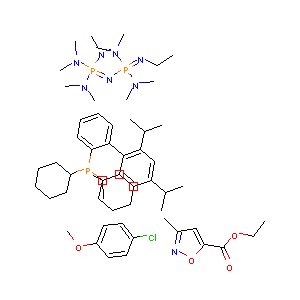

In [13]:
from rdkit.Chaem import Draw
Draw.MolToImage(mol)
#Chem.FindMolChiralCenters(mol,force=True)